
Full Description of GAN Training Code

This code implemented and trained a Deep Convolutional GAN (DCGAN) to generate realistic 64x64 RGB images.

- The dataset was loaded from a folder of images, which were resized, randomly flipped, rotated, 
  converted to tensors, and normalized to [-1, 1].

- The Generator network started with a 100-dimensional latent noise vector, then used a series 
  of ConvTranspose2d layers with batch normalization and ReLU activations to upsample the input, 
  finally outputting 3-channel images with tanh activation.

- The Discriminator network took images as input and used Conv2d layers with batch normalization 
  and LeakyReLU activations to downsample and classify images as real or fake, outputting a probability 
  with sigmoid activation.

- The networks were trained adversarially using binary cross-entropy loss:  
  - The Discriminator learned to distinguish real images from fake images generated by the Generator.  
  - The Generator learned to create images that fool the Discriminator.

- Training was conducted for 50 epochs with batch size 32, using Adam optimizers with learning rate 0.0002 and beta1=0.5.

- In each training iteration:  
  1. The Discriminator was updated on real images labeled as real.  
  2. The Discriminator was updated on fake images labeled as fake.  
  3. The Generator was updated to maximize the Discriminator’s error in classifying fake images.

- Fixed noise vectors were used to generate and save sample images every 5 epochs, helping track 
  the Generator’s improvement visually.

- After training, both the Generator and Discriminator model weights were saved for future use.

This implementation follows standard DCGAN guidelines and serves as a solid baseline for image generation tasks.



In [68]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
image_size = 64
batch_size = 32
nz = 100  # Latent vector (noise) size
num_epochs = 50
lr = 0.0002
beta1 = 0.5

# Image folder
image_path = r"C:\MurthyLab\GAN\images"

# Transform
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Correct for 3 channels
])

# Dataset & Dataloader
dataset = datasets.ImageFolder(root=image_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

# Initialize models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for monitoring progress
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        b_size = real_images.size(0)
        real_images = real_images.to(device)
        label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)

        # Train Discriminator with real images
        netD.zero_grad()
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train Discriminator with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.0)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Train Generator to fool the discriminator
        netG.zero_grad()
        label.fill_(1.0)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {(errD_real + errD_fake).item():.4f} Loss_G: {errG.item():.4f}")

    # Save generated images every 5 epochs
    if (epoch+1) % 5 == 0:
        vutils.save_image(netG(fixed_noise), f"generated_epoch_{epoch+1}.png", normalize=True)

# Save final models
torch.save(netG.state_dict(), "generator.pth")
torch.save(netD.state_dict(), "discriminator.pth")
print("✅ GAN training complete! Models saved.")


Epoch [1/50] Loss_D: 0.7109 Loss_G: 4.9508
Epoch [2/50] Loss_D: 0.6528 Loss_G: 7.3413
Epoch [3/50] Loss_D: 0.3685 Loss_G: 7.7052
Epoch [4/50] Loss_D: 0.8618 Loss_G: 11.3176
Epoch [5/50] Loss_D: 0.3013 Loss_G: 10.8246
Epoch [6/50] Loss_D: 0.2409 Loss_G: 12.1154
Epoch [7/50] Loss_D: 0.1601 Loss_G: 13.6529
Epoch [8/50] Loss_D: 3.2224 Loss_G: 12.4474
Epoch [9/50] Loss_D: 0.1555 Loss_G: 7.8039
Epoch [10/50] Loss_D: 0.6285 Loss_G: 12.1140
Epoch [11/50] Loss_D: 0.1134 Loss_G: 7.9194
Epoch [12/50] Loss_D: 0.3931 Loss_G: 7.5826
Epoch [13/50] Loss_D: 0.1129 Loss_G: 4.7005
Epoch [14/50] Loss_D: 0.4743 Loss_G: 10.0369
Epoch [15/50] Loss_D: 0.1598 Loss_G: 12.6688
Epoch [16/50] Loss_D: 0.1749 Loss_G: 6.7224
Epoch [17/50] Loss_D: 0.0544 Loss_G: 10.7738
Epoch [18/50] Loss_D: 0.8663 Loss_G: 10.6265
Epoch [19/50] Loss_D: 0.1863 Loss_G: 5.6287
Epoch [20/50] Loss_D: 0.8535 Loss_G: 11.5606
Epoch [21/50] Loss_D: 0.1738 Loss_G: 3.9954
Epoch [22/50] Loss_D: 0.3718 Loss_G: 8.1755
Epoch [23/50] Loss_D: 0.0733 L


This code snippet loads the generated image saved at epoch 50 ("generated_epoch_50.png") 
using the Python Imaging Library (PIL) and displays it.

- Image.open() opens the saved image file.
- img.show() launches the default image viewer to display the image.

This allows quick visualization of the GAN’s output after training.



In [69]:
from PIL import Image
img = Image.open("generated_epoch_50.png")
img.show()


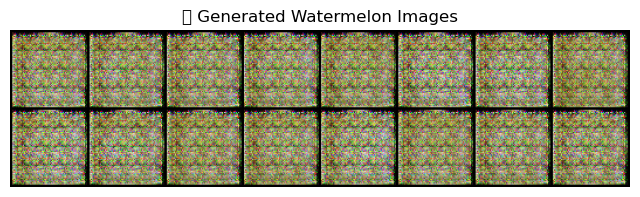

In [70]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# ✅ Define Generator (DCGAN style)
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# ✅ Generate new images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 100  # noise vector size
netG = Generator().to(device)
netG.load_state_dict(torch.load("generator.pth", map_location=device))
netG.eval()

noise = torch.randn(16, nz, 1, 1, device=device)
fake_images = netG(noise)

# ✅ Visualize output
grid = vutils.make_grid(fake_images.detach().cpu(), normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("🧠 Generated Watermelon Images")
plt.show()


Summary: Why GAN-generated images appear blurry due to small dataset

The GAN generated images that look blurry and lack fine details. This happened because the training dataset was too small. 

With limited data:
- The Generator struggles to learn diverse, high-quality features.
- The Discriminator cannot provide strong feedback to push the Generator toward sharper images.
- The model tends to produce averaged or smoothed outputs to minimize loss, resulting in blurred images.

To improve image quality:
- Increase the size and diversity of the training dataset.
- Use data augmentation to artificially enlarge the dataset.
- Train for more epochs to allow the model to better learn image features.
- Experiment with improved GAN architectures or loss functions that encourage sharper outputs.

In summary, small datasets limit GAN performance and cause blurry generated images.
